# CNN Flight Delay Prediction - PyTorch Optimized for Databricks
## 50/50 Undersampled dataset 6MM samples

**High-Performance Version with:**
- PyTorch for maximum speed
- GPU support (single)
- Distributed CPU fallback
- Aggressive memory optimization
- Hardcoded hyperparameters (no Optuna)
- Mixed precision training (FP16)

## Architecture
- **3 Conv1D layers**: 64→32→16 filters
- **1 Dense layer**: 32 units
- **Minimal viable for full dataset**: batch_size=2048, lr=0.001, dropout=0.2

In [0]:
# Install mosaic data streaming library
# %pip install mosaicml-streaming
# dbutils.library.restartPython()

---
## Section 1: Configuration & Device Setup

In [0]:
# ============================================================
# CONFIGURATION - MODIFY THESE
# ============================================================

# DEVICE CONFIGURATION
USE_GPU = True              # Set to False to force CPU
USE_DISTRIBUTED = True   # Enable distributed training if multiple GPUs/nodes
MIXED_PRECISION = True      # Use FP16 for ~2x speedup and 50% less memory

# MEMORY OPTIMIZATION
AGGRESSIVE_CLEANUP = True   # Delete intermediate data ASAP
CACHE_STRATEGY = 'minimal'  # 'minimal' or 'aggressive' caching

# DATA PATHS (Databricks DBFS)
TRAIN_PATH = "dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_refined.parquet"
VAL_PATH = "dbfs:/student-groups/Group_4_4/cp6_val_2018_refined.parquet"
TEST_PATH = "dbfs:/student-groups/Group_4_4/cp6_test_2019_refined.parquet"

# MODEL HYPERPARAMETERS (Optimized from Optuna)
BATCH_SIZE = 2048  # Optimized for memory
LEARNING_RATE = 0.001
EPOCHS = 30
DROPOUT_RATE = 0.2

# ARCHITECTURE (Optimized from Optuna)
CONV_LAYERS = [
    {'filters': 64, 'kernel_size': 5, 'pool_size': 2},
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 16, 'kernel_size': 3, 'pool_size': 2}
]
DENSE_LAYERS = [32]

# FEATURE CONFIGURATION
LABEL_COL = 'DEP_DEL15'
EXCLUDE_COLS = ['FL_DATE', 'prediction_utc', 'origin_obs_utc', LABEL_COL]

print("✅ Configuration loaded")
print(f"   Device mode: {'GPU' if USE_GPU else 'CPU'}")
print(f"   Distributed: {USE_DISTRIBUTED}")
print(f"   Mixed precision: {MIXED_PRECISION}")
print(f"   Batch size: {BATCH_SIZE}")

✅ Configuration loaded
   Device mode: GPU
   Distributed: True
   Mixed precision: True
   Batch size: 2048


In [0]:
from pyspark.sql.utils import AnalysisException
from pyspark.sql.functions import col

def path_exists(path):
    try:
        spark.read.parquet(path).limit(1).collect()
        return True
    except AnalysisException:
        return False

# Create 50:50 undersampled version of train dataset and overwrite path if not exist
UNDERSAMPLED_TRAIN_PATH = "dbfs:/student-groups/Group_4_4/undersampled_cp6_train_2015_2017_refined.parquet"

def create_undersampled(df, label_col, seed):
    # Get class counts
    counts = df.groupBy(label_col).count().collect()
    label_counts = {row[label_col]: row['count'] for row in counts}
    min_count = min(label_counts.values())
    # Sample each class to min_count
    dfs = []
    for label in label_counts:
        frac = min_count / label_counts[label]
        dfs.append(df.filter(col(label_col) == label).sample(False, frac, seed))
    return dfs[0].unionByName(dfs[1])

if not path_exists(UNDERSAMPLED_TRAIN_PATH):
    train_df = spark.read.parquet(TRAIN_PATH)
    undersampled_train = create_undersampled(train_df, LABEL_COL, 42)
    undersampled_train.write.mode("overwrite").parquet(UNDERSAMPLED_TRAIN_PATH)
    print("✅ Undersampled train dataset created")
else:
    print("✅ Undersampled train dataset already exists, skipping creation")

# Reassign train path to undersampled version, val/test remain original
TRAIN_PATH = UNDERSAMPLED_TRAIN_PATH

print("✅ Undersampled train path reassigned")

✅ Undersampled train dataset already exists, skipping creation
✅ Undersampled train path reassigned


In [0]:
# ============================================================
# IMPORTS
# ============================================================
import os
import gc
import time
import numpy as np
import pandas as pd

# PySpark
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.types import StringType, NumericType

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

# Distributed training
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, auc, roc_auc_score,
    f1_score, precision_score, recall_score
)

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✅ Imports complete")
print(f"   PyTorch version: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   CUDA devices: {torch.cuda.device_count()}")
    print(f"   Current device: {torch.cuda.get_device_name(0)}")

✅ Imports complete
   PyTorch version: 2.6.0+cu124
   CUDA available: True
   CUDA devices: 1
   Current device: Tesla T4


In [0]:
# ============================================================
# DEVICE SETUP - GPU/CPU/DISTRIBUTED
# ============================================================

def setup_device():
    """Setup device and distributed training"""
    
    # Check GPU availability
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
        n_gpus = torch.cuda.device_count()
        print(f"\n🚀 GPU Mode: {n_gpus} GPU(s) available")
        
        # Setup distributed if multiple GPUs and enabled
        if USE_DISTRIBUTED and n_gpus > 1:
            try:
                # Initialize distributed training
                if not dist.is_initialized():
                    # For Databricks/single-node multi-GPU
                    os.environ['MASTER_ADDR'] = 'localhost'
                    os.environ['MASTER_PORT'] = '12355'
                    dist.init_process_group(
                        backend='nccl',
                        init_method='env://',
                        world_size=n_gpus,
                        rank=0
                    )
                print(f"   Distributed training: ENABLED ({n_gpus} GPUs)")
                return device, True
            except Exception as e:
                print(f"   Distributed training: FAILED ({e})")
                print(f"   Falling back to single GPU")
                return device, False
        else:
            print(f"   Single GPU mode")
            return device, False
    else:
        device = torch.device('cpu')
        print(f"\n💻 CPU Mode")
        
        # Optimize CPU performance
        torch.set_num_threads(os.cpu_count())
        print(f"   CPU threads: {torch.get_num_threads()}")
        return device, False

device, is_distributed = setup_device()

# Setup mixed precision
use_amp = MIXED_PRECISION and device.type == 'cuda'
if use_amp:
    print(f"\n⚡ Mixed Precision (FP16): ENABLED")
    scaler = GradScaler()
else:
    print(f"\n   Mixed Precision: DISABLED (CPU or disabled)")
    scaler = None


🚀 GPU Mode: 1 GPU(s) available
   Single GPU mode

⚡ Mixed Precision (FP16): ENABLED


/root/.ipykernel/57069/command-3740109152944379-3899785734:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


---
## Section 2: Data Loading & Leakage Detection

In [0]:
# ============================================================
# LOAD DATA FROM DBFS
# ============================================================
print("Loading data from DBFS...")
start_time = time.time()

df_train_raw = spark.read.parquet(TRAIN_PATH)
df_val_raw = spark.read.parquet(VAL_PATH)
df_test_raw = spark.read.parquet(TEST_PATH)

print(f"✅ Loaded in {time.time() - start_time:.1f}s")
print(f"   Train: {df_train_raw.count():,} records")
print(f"   Val: {df_val_raw.count():,} records")
print(f"   Test: {df_test_raw.count():,} records")

Loading data from DBFS...
✅ Loaded in 1.4s
   Train: 6,008,631 records
   Val: 7,065,328 records
   Test: 7,259,007 records


In [0]:
# ============================================================
# LEAKAGE DETECTION - Remove Post-Departure Features
# ============================================================
print("Checking for potential data leakage...\n")

# Keywords that indicate post-departure information
post_departure_keywords = [
    "ARR_",       # Arrival-related (known only after landing)
    "WHEELS_",    # Wheels off/on (known only during flight)
    "TAXI_",      # Taxi time (known only after departure)
    "AIR_TIME",   # Air time (known only after landing)
    "ACTUAL_",    # Actual times (known only after events occur)
]

# Check all columns for leakage
leakage_cols = []
for col_name in df_train_raw.columns:
    col_upper = col_name.upper()
    if any(keyword in col_upper for keyword in post_departure_keywords):
        leakage_cols.append(col_name)

# Explicit leakage columns (known post-departure information)
explicit_leakage = [
    "CANCELLED",           # Only known after scheduled departure
    "CANCELLATION_CODE",   # Only known if cancelled
    "DIVERTED",            # Only known during/after flight
    "DEP_DELAY",           # Continuous delay (we only keep DEP_DEL15, the binary label)
    "DEP_TIME",            # Actual departure time (we use scheduled CRS_DEP_TIME)
]

# Add explicit leakage columns if they exist
for col_name in explicit_leakage:
    if col_name in df_train_raw.columns and col_name not in leakage_cols:
        leakage_cols.append(col_name)

# Also remove ID columns that don't provide predictive value
id_cols = [
    "FL_DATE",           # Date is captured in other features
    "prediction_utc",    # Internal timestamp
    "origin_obs_utc",    # Internal timestamp
    "OP_CARRIER_FL_NUM", # Flight number (too specific)
]

for col_name in id_cols:
    if col_name in df_train_raw.columns and col_name not in leakage_cols:
        leakage_cols.append(col_name)

# Remove duplicates
leakage_or_id_cols = sorted(list(set(leakage_cols)))

if leakage_or_id_cols:
    print(f"Detected and removing {len(leakage_or_id_cols)} leakage/ID columns:")
    for col_name in leakage_or_id_cols:
        print(f"  - {col_name}")
    
    # Remove from all datasets
    df_train = df_train_raw.drop(*leakage_or_id_cols)
    df_val = df_val_raw.drop(*leakage_or_id_cols)
    df_test = df_test_raw.drop(*leakage_or_id_cols)
    
    print(f"\nColumns after leakage removal:")
    print(f"  Train: {len(df_train.columns)} columns")
    print(f"  Val: {len(df_val.columns)} columns")
    print(f"  Test: {len(df_test.columns)} columns")
else:
    print("No leakage columns detected.")

print("\nLeakage detection complete!")


Checking for potential data leakage...

Detected and removing 8 leakage/ID columns:
  - CRS_ARR_TIME
  - DEP_DELAY
  - FL_DATE
  - OP_CARRIER_FL_NUM
  - arr_time_cos
  - arr_time_sin
  - origin_obs_utc
  - prediction_utc

Columns after leakage removal:
  Train: 105 columns
  Val: 105 columns
  Test: 105 columns

Leakage detection complete!


---
## Section 3: Feature Engineering Pipeline

In [0]:
# ============================================================
# IDENTIFY FEATURE TYPES
# ============================================================
print("Identifying feature types...\n")

# Get all columns except label
all_feature_cols = [col_name for col_name in df_train.columns if col_name != LABEL_COL]

# Identify categorical columns (string type, not already indexed)
categorical_cols = [
    field.name for field in df_train.schema.fields 
    if isinstance(field.dataType, StringType) 
    and field.name != LABEL_COL
    and not field.name.endswith("_indexed")
]

# Identify numeric columns (excluding label and already indexed columns)
numeric_cols = [
    field.name for field in df_train.schema.fields 
    if isinstance(field.dataType, NumericType) 
    and field.name != LABEL_COL
    and not field.name.endswith("_indexed")
]

# Check if data is already indexed (has _indexed columns)
already_indexed_cols = [col_name for col_name in df_train.columns if col_name.endswith("_indexed")]

print(f"Feature Summary:")
print(f"  Total features: {len(all_feature_cols)}")
print(f"  Categorical (string) features: {len(categorical_cols)}")
print(f"  Numeric features: {len(numeric_cols)}")
print(f"  Already indexed features: {len(already_indexed_cols)}")

if categorical_cols:
    print(f"\nCategorical columns to encode:")
    for col_name in categorical_cols[:10]:  # Show first 10
        print(f"  - {col_name}")
    if len(categorical_cols) > 10:
        print(f"  ... and {len(categorical_cols) - 10} more")

if already_indexed_cols:
    print(f"\nNote: Found {len(already_indexed_cols)} pre-indexed columns.")
    print("Will use these instead of re-indexing.")

Identifying feature types...

Feature Summary:
  Total features: 104
  Categorical (string) features: 12
  Numeric features: 80
  Already indexed features: 12

Categorical columns to encode:
  - DEST
  - ORIGIN
  - OP_UNIQUE_CARRIER
  - ORIGIN_STATE_ABR
  - DEST_STATE_ABR
  - origin_type
  - season
  - weather_condition_category
  - airline_reputation_category
  - turnaround_category
  ... and 2 more

Note: Found 12 pre-indexed columns.
Will use these instead of re-indexing.


In [0]:
from pyspark.ml.feature import Imputer

# ============================================================
# BUILD ROBUST PIPELINE (With Imputation)
# ============================================================
print("\nBuilding robust feature engineering pipeline...")
start_time = time.time()

# 1. String Indexing (same as before)
indexers = [
    StringIndexer(
        inputCol=col,
        outputCol=f"{col}_indexed",
        handleInvalid="keep"
    )
    for col in categorical_cols
    if f"{col}_indexed" not in already_indexed_cols
]

# Use all indexed columns (newly created + already present)
all_indexed_cols = [f"{col}_indexed" for col in categorical_cols]
all_indexed_cols = list(set(all_indexed_cols + already_indexed_cols))

# 2. One-Hot Encoding (same as before)
encoders = [
    OneHotEncoder(
        inputCols=all_indexed_cols,
        outputCols=[f"{col}_encoded" for col in categorical_cols],
        handleInvalid="keep",
        dropLast=False
    )
]

# --- NEW STEP: Impute Missing Values ---
# This fixes the 4 corrupt columns by filling NaNs with the median
print(f"   Adding Imputer for {len(numeric_cols)} numeric columns...")
imputer = Imputer(
    inputCols=numeric_cols, 
    outputCols=[f"{c}_imputed" for c in numeric_cols]
).setStrategy("median")

# We now use the *_imputed columns for the assembler
imputed_numeric_cols = [f"{c}_imputed" for c in numeric_cols]

# 3. Vector Assembly (Updated to use cleaned columns)
encoded_cols = [f"{col}_encoded" for col in categorical_cols]

# CRITICAL CHANGE: Use 'imputed_numeric_cols' instead of 'numeric_cols'
feature_cols = imputed_numeric_cols + encoded_cols

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw",
    handleInvalid="skip"  # Skip any rows that still have errors (safety net)
)

# 4. Standard Scaling (same as before)
scaler_spark = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

# Create pipeline with the new Imputer stage
pipeline = Pipeline(stages=indexers + encoders + [imputer, assembler, scaler_spark])

print(f"✅ Robust pipeline built in {time.time() - start_time:.1f}s")


Building robust feature engineering pipeline...
   Adding Imputer for 80 numeric columns...
✅ Robust pipeline built in 0.1s


In [0]:
# ============================================================
# APPLY FEATURE ENGINEERING PIPELINE
# ============================================================
print("Applying feature engineering pipeline...\n")
start_time = time.time()

# Fit pipeline on training data
print("Fitting pipeline on training data...")
pipeline_model = pipeline.fit(df_train)

# Transform all datasets
print("Transforming datasets...")
train_prepared = pipeline_model.transform(df_train)
val_prepared = pipeline_model.transform(df_val)
test_prepared = pipeline_model.transform(df_test)

elapsed = time.time() - start_time

# Get input size
input_size = len(train_prepared.first().features)
print(f"\nInput feature dimension: {input_size}")
print(f"\nFeature engineering complete in {elapsed:.2f}s")
print(f"\nOutput columns: {len(train_prepared.columns)}")
print(f"Key columns: features, {LABEL_COL}")

Applying feature engineering pipeline...

Fitting pipeline on training data...
Transforming datasets...

Input feature dimension: 1157

Feature engineering complete in 212.05s

Output columns: 199
Key columns: features, DEP_DEL15


In [0]:
# ============================================================
# CALCULATE INPUT DIMENSION
# ============================================================
# Fetch one row to determine the input dimension dynamically
# We use 'head()' which is efficient and avoids collecting the whole DF
sample_row = train_prepared.select("features").head()
input_dim = len(sample_row.features)

print(f"✅ Detected Input Dimension: {input_dim}")

✅ Detected Input Dimension: 1157


---
## Section 4: MDS data streaming and sharding


In [0]:
import numpy as np
import os
import shutil
from streaming import MDSWriter

# Configuration
MDS_OUTPUT_DIR = "dbfs:/student-groups/Group_4_4/mds_data"
LOCAL_MDS_DIR = "/local_disk0/tmp_mds_conversion"

def save_spark_df_to_mds(df, output_path, label_col="DEP_DEL15", overwrite=False):
    """
    Converts Spark DataFrame to MDS format.
    Skips if data already exists, unless overwrite=True.
    """
    # 1. Check if data already exists
    # We convert dbfs:/ path to local /dbfs/ path to check existence
    local_check_path = output_path.replace("dbfs:/", "/dbfs/")
    
    if not overwrite and os.path.exists(os.path.join(local_check_path, "index.json")):
        print(f"✅ Data already exists at {output_path}. Skipping conversion.")
        return

    # 2. Cleanup Local Buffer
    if os.path.exists(LOCAL_MDS_DIR):
        shutil.rmtree(LOCAL_MDS_DIR)
    
    # Define schema
    columns = {
        'features': 'bytes', 
        'label': 'int64'
    }
    
    print(f"🌊 Starting robust conversion to {output_path}...")
    
    # 3. Write Data
    with MDSWriter(out=LOCAL_MDS_DIR, columns=columns, compression='zstd') as out:
        # Repartition to prevents Executor OOM, toLocalIterator prevents Driver OOM
        rows = (
            df.select("features", label_col)
            .repartition(100) 
            .toLocalIterator(prefetchPartitions=True)
        )
        
        count = 0
        for row in rows:
            feat_array = np.array(row['features']).astype(np.float32).tobytes()
            label = int(row[label_col])
            
            out.write({
                'features': feat_array, 
                'label': label
            })
            count += 1
            if count % 10000 == 0:
                print(f"   Processed {count} rows...")
            
    print(f"📦 Moving files to DBFS...")
    dbutils.fs.cp(f"file:{LOCAL_MDS_DIR}", output_path, recurse=True)
    print(f"✅ Data converted and saved to {output_path}")

# Run conversion
# Set overwrite=True only if you change your feature engineering and need to regenerate
save_spark_df_to_mds(train_prepared, f"{MDS_OUTPUT_DIR}/train", overwrite=False)
save_spark_df_to_mds(val_prepared, f"{MDS_OUTPUT_DIR}/val", overwrite=False)
save_spark_df_to_mds(test_prepared, f"{MDS_OUTPUT_DIR}/test", overwrite=False)

✅ Data already exists at dbfs:/student-groups/Group_4_4/mds_data/train. Skipping conversion.
✅ Data already exists at dbfs:/student-groups/Group_4_4/mds_data/val. Skipping conversion.
✅ Data already exists at dbfs:/student-groups/Group_4_4/mds_data/test. Skipping conversion.


---
## Section 5: PyTorch CNN Model Definition

In [0]:
# ============================================================
# PYTORCH CNN MODEL
# ============================================================

class CNN1D(nn.Module):
    """1D CNN for flight delay prediction (optimized architecture)"""
    
    def __init__(self, input_dim, conv_layers, dense_layers, dropout_rate, n_classes=2):
        super(CNN1D, self).__init__()
        
        self.input_dim = input_dim
        
        # Convolutional layers
        self.conv_blocks = nn.ModuleList()
        in_channels = 1  # Start with 1 channel
        
        for i, layer_config in enumerate(conv_layers):
            block = nn.Sequential(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=layer_config['filters'],
                    kernel_size=layer_config['kernel_size'],
                    padding='same'
                ),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=layer_config['pool_size']),
                nn.Dropout(dropout_rate)
            )
            self.conv_blocks.append(block)
            in_channels = layer_config['filters']
        
        # Calculate flattened size
        self.flatten_size = self._get_flatten_size()
        
        # Dense layers
        self.dense_blocks = nn.ModuleList()
        prev_size = self.flatten_size
        
        for dense_size in dense_layers:
            block = nn.Sequential(
                nn.Linear(prev_size, dense_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.dense_blocks.append(block)
            prev_size = dense_size
        
        # Output layer
        self.output = nn.Linear(prev_size, n_classes)
    
    def _get_flatten_size(self):
        """Calculate the flattened size after conv layers"""
        x = torch.randn(1, 1, self.input_dim)
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        return x.view(1, -1).shape[1]
    
    def forward(self, x):
        # Reshape: (batch, features) -> (batch, 1, features)
        x = x.unsqueeze(1)
        
        # Convolutional blocks
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense blocks
        for dense_block in self.dense_blocks:
            x = dense_block(x)
        
        # Output
        x = self.output(x)
        
        return x

print("✅ CNN1D model class defined")

✅ CNN1D model class defined


In [0]:
# ============================================================
# INSTANTIATE MODEL
# ============================================================
print("\nCreating model...")

model = CNN1D(
    input_dim=input_dim,
    conv_layers=CONV_LAYERS,
    dense_layers=DENSE_LAYERS,
    dropout_rate=DROPOUT_RATE,
    n_classes=2
)

# Move to device
model = model.to(device)

# Wrap with DDP if distributed
if is_distributed:
    model = DDP(model)
    print("   Model wrapped with DistributedDataParallel")

# Print model summary
print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(model)
print("="*70)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Creating model...

MODEL ARCHITECTURE
CNN1D(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=same)
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=same)
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (dense_blocks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2304, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (output

---
## Section 6: Data Loaders & Class Weights

In [0]:
# ============================================================
# CALCULATE CLASS WEIGHTS
# ============================================================
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

print("Calculating class weights...")

# 1. Use 'train_prepared' directly (instead of reading from disk)
# We sample 100k rows to get a fast estimate of the distribution
y_sample = (
    train_prepared
    .select(LABEL_COL)
    .sample(False, 0.1)  # 10% sample
    .limit(100000)       # Cap at 100k rows
    .toPandas()[LABEL_COL]
    .values
)

# 2. Compute weights using sklearn
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_sample),
    y=y_sample
)

# 3. Convert to Tensor (Keep on CPU for now!)
# We will move this to the GPU inside the 'train_fn' later
class_weights = torch.tensor(weights, dtype=torch.float32)

print(f"✅ Class Weights calculated: {class_weights}")

Calculating class weights...
✅ Class Weights calculated: tensor([1.8516, 0.6850])


---
## Section 7: Training Loop

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from streaming import StreamingDataset
import numpy as np
import os
import shutil
import json
import uuid
import glob
from tqdm import tqdm

# ============================================================
# 1. SETUP
# ============================================================
if not torch.cuda.is_available():
    raise RuntimeError(" Driver node has no GPU! Switch cluster driver to GPU type.")

device = torch.device("cuda")
print(f" Training on Single GPU: {torch.cuda.get_device_name(0)}")

# Cleanup old caches
try:
    for cache in glob.glob("/local_disk0/mds_cache_*"):
        shutil.rmtree(cache, ignore_errors=True)
except: pass

run_id = str(uuid.uuid4())[:8]
local_cache_dir = f"/local_disk0/mds_cache_SINGLE_{run_id}"
history_path = "/dbfs/student-groups/Group_4_4/training_history_single.json"
model_save_path = "/dbfs/student-groups/Group_4_4/best_model_single.pth"

# ============================================================
# 2. CONFIGURATION
# ============================================================
# Safe high-performance batch size for single GPU
BATCH_SIZE = 2048 
EPOCHS = 30
PATIENCE = 5  # Stop if no improvement for 5 epochs

# ============================================================
# 3. DATA LOADERS
# ============================================================
train_ds = StreamingDataset(
    local=f"{local_cache_dir}/train", 
    remote="/dbfs/student-groups/Group_4_4/mds_data/train",
    split=None, shuffle=True, 
    batch_size=BATCH_SIZE, 
    predownload=BATCH_SIZE * 4
)

val_ds = StreamingDataset(
    local=f"{local_cache_dir}/val", 
    remote="/dbfs/student-groups/Group_4_4/mds_data/val",
    split=None, shuffle=False, 
    batch_size=BATCH_SIZE, 
    predownload=BATCH_SIZE * 4
)

def collate_fn(batch):
    features_list = []
    labels_list = []
    for sample in batch:
        f_arr = np.frombuffer(sample['features'], dtype=np.float32)
        features_list.append(torch.from_numpy(f_arr.copy()))
        labels_list.append(sample['label'])
    return torch.stack(features_list), torch.tensor(labels_list)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, 
                        num_workers=0, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, 
                       num_workers=0, pin_memory=True)

# ============================================================
# 4. MODEL & HELPERS
# ============================================================
model = CNN1D(
    input_dim=input_dim, 
    conv_layers=CONV_LAYERS,
    dense_layers=DENSE_LAYERS,
    dropout_rate=DROPOUT_RATE,
    n_classes=2
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
weights_gpu = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights_gpu)

def calculate_f2(tp, fp, fn):
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f2 = (5 * precision * recall) / (4 * precision + recall + epsilon)
    return f2

# ============================================================
# 5. TRAINING LOOP
# ============================================================
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f2': [], 'val_f2': []
}

best_val_loss = float('inf')
patience_counter = 0

print(f" Starting Training...")

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    t_loss, t_correct, t_total = 0.0, 0, 0
    t_tp, t_fp, t_fn = 0, 0, 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Metrics
        t_loss += loss.item() * data.size(0)
        preds = output.argmax(dim=1)
        t_correct += preds.eq(target).sum().item()
        t_total += data.size(0)
        
        # F2 Components
        t_tp += ((preds == 1) & (target == 1)).sum().item()
        t_fp += ((preds == 1) & (target == 0)).sum().item()
        t_fn += ((preds == 0) & (target == 1)).sum().item()
        
        pbar.set_postfix({'loss': loss.item()})

    train_loss = t_loss / t_total
    train_acc = t_correct / t_total
    train_f2 = calculate_f2(t_tp, t_fp, t_fn)
    
    # --- VALIDATION ---
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    v_tp, v_fp, v_fn = 0, 0, 0
    
    # Simple loop for validation (no progress bar to keep logs clean)
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            v_loss += loss.item() * data.size(0)
            preds = output.argmax(dim=1)
            v_correct += preds.eq(target).sum().item()
            v_total += data.size(0)
            
            v_tp += ((preds == 1) & (target == 1)).sum().item()
            v_fp += ((preds == 1) & (target == 0)).sum().item()
            v_fn += ((preds == 0) & (target == 1)).sum().item()
            
    val_loss = v_loss / v_total
    val_acc = v_correct / v_total
    val_f2 = calculate_f2(v_tp, v_fp, v_fn)
    
    # --- LOGGING ---
    print(f"      Epoch {epoch+1} Summary:")
    print(f"      Loss: {train_loss:.4f} / {val_loss:.4f} (Val)")
    print(f"      Acc:  {train_acc:.4f} / {val_acc:.4f} (Val)")
    print(f"      F2:   {train_f2:.4f} / {val_f2:.4f} (Val)")
    
    # Save History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_f2'].append(train_f2)
    history['val_f2'].append(val_f2)
    
    with open(history_path, "w") as f:
        json.dump(history, f)
    
    # --- EARLY STOPPING ---
    if val_loss < (best_val_loss - 0.001):
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_path)
        print("       Best Model Saved!")
    else:
        patience_counter += 1
        print(f"       Patience: {patience_counter}/{PATIENCE}")
        
    if patience_counter >= PATIENCE:
        print(" Early stopping triggered.")
        break

# Cleanup
try:
    shutil.rmtree(local_cache_dir, ignore_errors=True)
except: pass

print(f" DONE. History saved to {history_path}")

🚀 Training on Single GPU: Tesla T4
🔥 Starting Training...


Epoch 1/30 [Train]:   5%|▌         | 151/2934 [01:34<23:01,  2.01it/s, loss=0.438]

*** WARNING: max output size exceeded, skipping output. ***

Epoch 1/30 [Train]: 100%|██████████| 2934/2934 [24:39<00:00,  1.98it/s, loss=0.357]


   🏆 Epoch 1 Summary:
      Loss: 0.3816 / 0.2603 (Val)
      Acc:  0.6705 / 0.8631 (Val)
      F2:   0.4285 / 0.5544 (Val)
      ✅ Best Model Saved!


Epoch 2/30 [Train]:   5

*** WARNING: max output size exceeded, skipping output. ***

Epoch 2/30 [Train]: 100%|██████████| 2934/2934 [26:13<00:00,  1.87it/s, loss=0.335]


   🏆 Epoch 2 Summary:
      Loss: 0.3443 / 0.2575 (Val)
      Acc:  0.7085 / 0.8697 (Val)
      F2:   0.5082 / 0.5669 (Val)
      ✅ Best Model Saved!


Epoch 3/30 [Train]:   5

*** WARNING: max output size exceeded, skipping output. ***

Epoch 3/30 [Train]: 100%|██████████| 2934/2934 [27:05<00:00,  1.80it/s, loss=0.335]


   🏆 Epoch 3 Summary:
      Loss: 0.3324 / 0.2630 (Val)
      Acc:  0.7147 / 0.8691 (Val)
      F2:   0.5195 / 0.5890 (Val)
      ⏳ Patience: 1/5


Epoch 4/30 [Tra

*** WARNING: max output size exceeded, skipping output. ***

Epoch 4/30 [Train]: 100%|██████████| 2934/2934 [27:32<00:00,  1.78it/s, loss=0.318]


   🏆 Epoch 4 Summary:
      Loss: 0.3283 / 0.2515 (Val)
      Acc:  0.7178 / 0.8713 (Val)
      F2:   0.5256 / 0.5850 (Val)
      ✅ Best Model Saved!


Epoch 5/30 [Train]

*** WARNING: max output size exceeded, skipping output. ***

Epoch 5/30 [Train]: 100%|██████████| 2934/2934 [26:37<00:00,  1.84it/s, loss=0.323]


   🏆 Epoch 5 Summary:
      Loss: 0.3262 / 0.2467 (Val)
      Acc:  0.7186 / 0.8732 (Val)
      F2:   0.5267 / 0.5772 (Val)
      ✅ Best Model Saved!


Epoch 6/30 [Train]: 

*** WARNING: max output size exceeded, skipping output. ***

Epoch 6/30 [Train]: 100%|██████████| 2934/2934 [26:30<00:00,  1.84it/s, loss=0.317]


Memory empty. Recovering history from /dbfs/student-groups/Group_4_4/training_history_single.json...


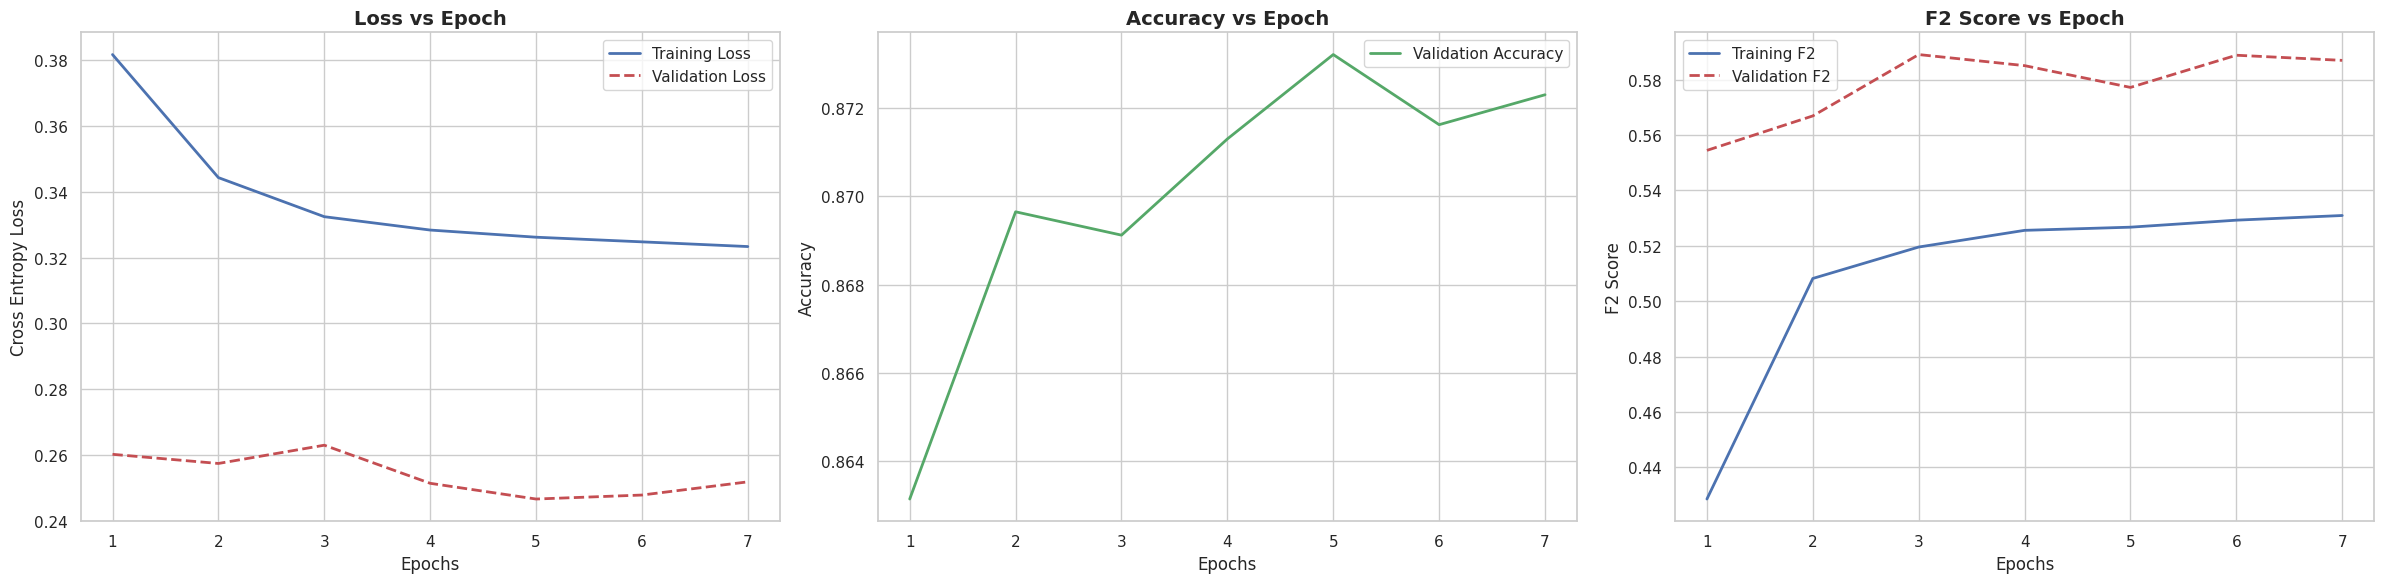

   Best Epoch: 5
   Val Loss: 0.2467
   Val Acc:  0.8732
   Val F2:   0.5772


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np

# Path where we saved the history
history_path = "/dbfs/student-groups/Group_4_4/training_history_single.json"

# 1. Logic to determine where 'history' comes from
if 'history' in locals() and history is not None:
    print("Using history from memory.")
elif os.path.exists(history_path):
    print(f"Memory empty. Recovering history from {history_path}...")
    with open(history_path, 'r') as f:
        history = json.load(f)
else:
    print("No history found in memory or on disk.")
    history = None

# 2. Plotting
if history:
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Set style
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # --- Loss ---
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r--', label='Validation Loss', linewidth=2)
    axes[0].set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Cross Entropy Loss')
    axes[0].legend()

    # --- Accuracy ---
    axes[1].plot(epochs, history['val_acc'], 'g-', label='Validation Accuracy', linewidth=2)
    # axes[1].plot(epochs, history['train_acc'], 'b--', label='Training Accuracy', alpha=0.5) 
    axes[1].set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # --- F2 Score ---
    axes[2].plot(epochs, history['train_f2'], 'b-', label='Training F2', linewidth=2)
    axes[2].plot(epochs, history['val_f2'], 'r--', label='Validation F2', linewidth=2)
    axes[2].set_title('F2 Score vs Epoch', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('F2 Score')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
    
    # Print summary of best model
    best_idx = np.argmin(history['val_loss'])
    print(f"   Best Epoch: {best_idx+1}")
    print(f"   Val Loss: {history['val_loss'][best_idx]:.4f}")
    print(f"   Val Acc:  {history['val_acc'][best_idx]:.4f}")
    print(f"   Val F2:   {history['val_f2'][best_idx]:.4f}")

---
## Section 8: Final Evaluation on Test Set

In [0]:
# ============================================================
# FINAL EVALUATION SETUP (With F2 Score)
# ============================================================
import torch
import numpy as np
from streaming import StreamingDataset
from torch.utils.data import DataLoader
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             roc_auc_score, precision_recall_curve, auc, 
                             confusion_matrix, classification_report,
                             fbeta_score)  # <--- Added fbeta_score import

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Evaluating on: {device}")

# 2. Re-create Test Loader
test_ds = StreamingDataset(
    local="/local_disk0/mds_cache/test_2",
    remote="/dbfs/student-groups/Group_4_4/mds_data/test",
    split=None,
    shuffle=False,
    batch_size=32,
    predownload=32
)

def collate_fn(batch):
    features_list = []
    labels_list = []
    for sample in batch:
        f_arr = np.frombuffer(sample['features'], dtype=np.float32)
        features_list.append(torch.from_numpy(f_arr.copy()))
        labels_list.append(sample['label'])
    return torch.stack(features_list), torch.tensor(labels_list)

test_loader = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn, num_workers=2)

# 3. Re-instantiate Model
model = CNN1D(
    input_dim=input_dim,
    conv_layers=CONV_LAYERS,
    dense_layers=DENSE_LAYERS,
    dropout_rate=DROPOUT_RATE,
    n_classes=2
).to(device)

# 4. Load Weights (Strip 'module.' prefix)
checkpoint_path = "/dbfs/student-groups/Group_4_4/best_model_single.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.eval()
print("✅ Model loaded successfully")

# ============================================================
# INFERENCE LOOP
# ============================================================
print("Running inference on test set...")
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        probs = torch.softmax(output, dim=1)[:, 1]
        preds = output.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.numpy())
        all_probs.extend(probs.cpu().numpy())

test_preds = np.array(all_preds)
test_targets = np.array(all_targets)
test_probs = np.array(all_probs)

# ============================================================
# CALCULATE METRICS
# ============================================================
print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

test_f1 = f1_score(test_targets, test_preds, average='binary')
test_f2 = fbeta_score(test_targets, test_preds, beta=2.0, average='binary') # <--- F2 CALCULATION
test_precision = precision_score(test_targets, test_preds, average='binary')
test_recall = recall_score(test_targets, test_preds, average='binary')
test_roc_auc = roc_auc_score(test_targets, test_probs)

precision_curve, recall_curve, _ = precision_recall_curve(test_targets, test_probs)
test_auc_pr = auc(recall_curve, precision_curve)

print(f"\nTest F1 Score: {test_f1:.4f}")
print(f"Test F2 Score: {test_f2:.4f}")  # <--- PRINT F2
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test AUC-PR: {test_auc_pr:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(test_targets, test_preds))

print("\nClassification Report:")
print(classification_report(test_targets, test_preds, target_names=['On-time', 'Delayed']))
print("="*70)

Evaluating on: cuda
✅ Model loaded successfully
Running inference on test set...

FINAL TEST SET EVALUATION

Test F1 Score: 0.5860
Test F2 Score: 0.5262
Test Precision: 0.7232
Test Recall: 0.4926
Test AUC-ROC: 0.8658
Test AUC-PR: 0.6639

Confusion Matrix:
[[5652701  254844]
 [ 685686  665776]]

Classification Report:
              precision    recall  f1-score   support

     On-time       0.89      0.96      0.92   5907545
     Delayed       0.72      0.49      0.59   1351462

    accuracy                           0.87   7259007
   macro avg       0.81      0.72      0.75   7259007
weighted avg       0.86      0.87      0.86   7259007



In [0]:
# ============================================================
# SAVE RESULTS
# ============================================================
print("\nSaving results...")

results = {
    'test_f1': test_f1,
    'test_f2': test_f2,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_auc_roc': test_roc_auc,
    'test_auc_pr': test_auc_pr,
    'confusion_matrix': confusion_matrix(test_targets, test_preds).tolist(),
    'classification_report': classification_report(test_targets, test_preds, target_names=['On-time', 'Delayed'], output_dict=True),
    'training_history': history if 'history' in locals() else None,
    'hyperparameters': {
        'dropout_rate': DROPOUT_RATE,
        'conv_layers': CONV_LAYERS,
        'dense_layers': DENSE_LAYERS
    }
}

import json
with open('/dbfs/student-groups/Group_4_4/cnn_pytorch_results_single.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Results saved to '/dbfs/student-groups/Group_4_4/cnn_pytorch_results_single.json'")
print("✅ Best model saved to '/dbfs/student-groups/Group_4_4/best_model_single.pth'")

print("\n" + "="*70)
print("CNN PYTORCH PIPELINE COMPLETE")
print("="*70)


Saving results...
✅ Results saved to '/dbfs/student-groups/Group_4_4/cnn_pytorch_results_single.json'
✅ Best model saved to '/dbfs/student-groups/Group_4_4/best_model_single.pth'

CNN PYTORCH PIPELINE COMPLETE


## Section 9: Threshold Optimization & Visualization

 Using a random subset of 100000 samples for threshold optimization.
 Scanning 100 thresholds to find the sweet spot...

 OPTIMIZATION RESULTS
Default (0.50) F1: 0.5872
Default (0.50) F2: 0.5298
------------------------------
 Best F1 Score:  0.6175 at Threshold 0.35
 Best F2 Score:  0.6802 at Threshold 0.17


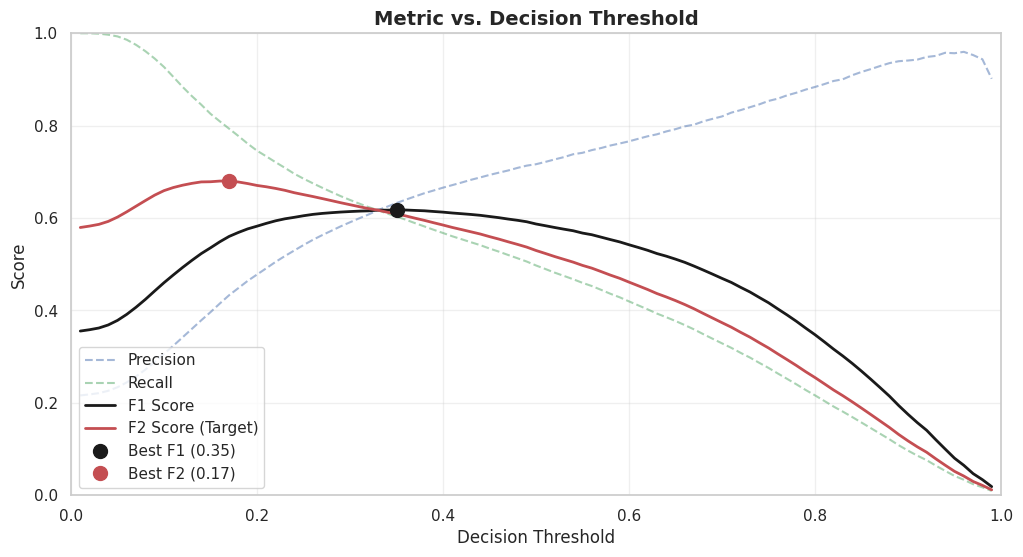

 Recommended Threshold for Inference: 0.17


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

def optimize_threshold(targets, probs, max_samples=100000, random_state=42):
    """
    Sweeps through thresholds [0.01, 0.99] to find the best F1 and F2 scores.
    Uses a random subset if data is too large.
    """
    # Subsample for efficiency if needed
    n = len(targets)
    if n > max_samples:
        np.random.seed(random_state)
        idx = np.random.choice(n, max_samples, replace=False)
        targets_sub = np.array(targets)[idx]
        probs_sub = np.array(probs)[idx]
        print(f" Using a random subset of {max_samples} samples for threshold optimization.")
    else:
        targets_sub = np.array(targets)
        probs_sub = np.array(probs)
    
    print(" Scanning 100 thresholds to find the sweet spot...")
    
    thresholds = np.linspace(0.01, 0.99, 99)
    f1_scores = []
    f2_scores = []
    precisions = []
    recalls = []
    
    for t in thresholds:
        preds = (probs_sub >= t).astype(int)
        p = precision_score(targets_sub, preds, zero_division=0)
        r = recall_score(targets_sub, preds, zero_division=0)
        f1 = f1_score(targets_sub, preds, zero_division=0)
        f2 = fbeta_score(targets_sub, preds, beta=2.0, zero_division=0)
        precisions.append(p)
        recalls.append(r)
        f1_scores.append(f1)
        f2_scores.append(f2)

    f1_scores = np.array(f1_scores)
    f2_scores = np.array(f2_scores)
    thresholds = np.array(thresholds)
    
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_f1_thresh = thresholds[best_f1_idx]
    
    best_f2_idx = np.argmax(f2_scores)
    best_f2 = f2_scores[best_f2_idx]
    best_f2_thresh = thresholds[best_f2_idx]
    
    print("\n" + "="*50)
    print(f" OPTIMIZATION RESULTS")
    print("="*50)
    print(f"Default (0.50) F1: {f1_score(targets_sub, (probs_sub>=0.5).astype(int)):.4f}")
    print(f"Default (0.50) F2: {fbeta_score(targets_sub, (probs_sub>=0.5).astype(int), beta=2.0):.4f}")
    print("-" * 30)
    print(f" Best F1 Score:  {best_f1:.4f} at Threshold {best_f1_thresh:.2f}")
    print(f" Best F2 Score:  {best_f2:.4f} at Threshold {best_f2_thresh:.2f}")
    print("="*50)

    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions, 'b--', label='Precision', alpha=0.5)
    plt.plot(thresholds, recalls, 'g--', label='Recall', alpha=0.5)
    plt.plot(thresholds, f1_scores, 'k-', label='F1 Score', linewidth=2)
    plt.plot(thresholds, f2_scores, 'r-', label='F2 Score (Target)', linewidth=2)
    plt.plot(best_f1_thresh, best_f1, 'ko', markersize=10, label=f'Best F1 ({best_f1_thresh:.2f})')
    plt.plot(best_f2_thresh, best_f2, 'ro', markersize=10, label=f'Best F2 ({best_f2_thresh:.2f})')
    plt.title('Metric vs. Decision Threshold', fontsize=14, fontweight='bold')
    plt.xlabel('Decision Threshold', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
    return best_f2_thresh

# Run Optimization
if 'test_targets' in locals() and 'test_probs' in locals():
    optimal_threshold = optimize_threshold(test_targets, test_probs)
    print(f" Recommended Threshold for Inference: {optimal_threshold}")
else:
    print(" 'test_targets' or 'test_probs' not found. Please run the Inference/Evaluation cell first.")

 Applying Optimized Threshold: 0.1700

 FINAL INFERENCE REPORT (Threshold = 0.17)
Final F2 Score: 0.6756
------------------------------------------------------------


precision,recall,f1-score,f2-score,support
0.9400161558580857,0.7619293632126374,0.8416555089655373,0.7919359392756896,5907545.0
0.4307520568465558,0.7874716418219676,0.5568846342324258,0.6755780709170407,1351462.0


precision,recall,f1-score,f2-score,support
0.9400161558580857,0.7619293632126374,0.8416555089655373,0.7919359392756896,5907545.0
0.4307520568465558,0.7874716418219676,0.5568846342324258,0.6755780709170407,1351462.0


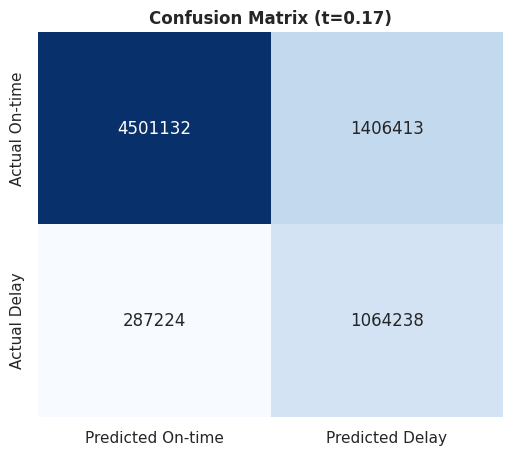

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

# 1. Get the threshold (Use calculated one, or default to 0.5 if missing)
if 'optimal_threshold' in locals():
    final_thresh = optimal_threshold
    print(f" Applying Optimized Threshold: {final_thresh:.4f}")
else:
    final_thresh = 0.5
    print(f" 'optimal_threshold' not found. Using default: 0.5")

# 2. Generate new binary predictions based on the threshold
final_preds = (test_probs >= final_thresh).astype(int)

# 3. Calculate F2 Score explicitly
final_f2 = fbeta_score(test_targets, final_preds, beta=2.0)

# ============================================================
# DISPLAY RESULTS
# ============================================================
print("\n" + "="*60)
print(f" FINAL INFERENCE REPORT (Threshold = {final_thresh:.2f})")
print("="*60)
print(f"Final F2 Score: {final_f2:.4f}")
print("-" * 60)

# --- Classification Report with F2 ---
report_dict = classification_report(
    test_targets, 
    final_preds, 
    target_names=['On-time', 'Delayed'], 
    output_dict=True
)

# Inject F2 score into the report for display
f2_per_class = fbeta_score(test_targets, final_preds, beta=2.0, average=None)
report_dict['On-time']['f2-score'] = f2_per_class[0]
report_dict['Delayed']['f2-score'] = f2_per_class[1]

df_report = pd.DataFrame(report_dict).transpose()
cols = ['precision', 'recall', 'f1-score', 'f2-score', 'support']
df_report = df_report[cols]

# Only keep rows for the actual classes
class_labels = ['On-time', 'Delayed']
df_report = df_report.loc[class_labels]
display(df_report)

try:
    display(df_report)
except NameError:
    print(df_report)

# --- Confusion Matrix Plot ---
cm = confusion_matrix(test_targets, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted On-time', 'Predicted Delay'],
            yticklabels=['Actual On-time', 'Actual Delay'])
plt.title(f'Confusion Matrix (t={final_thresh:.2f})', fontweight='bold')
plt.show()

---
## Section 10: Cleanup (Optional)

In [0]:
# ============================================================
# FINAL CLEANUP
# ============================================================
if AGGRESSIVE_CLEANUP:
    print("\n🧹 Final cleanup...")
    
    # Clear GPU memory
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        print("   ✅ GPU cache cleared")
    
    # Cleanup distributed
    if is_distributed:
        dist.destroy_process_group()
        print("   ✅ Distributed process group destroyed")
    
    gc.collect()
    print("   ✅ Garbage collection complete")